# NFL Draft Data Processing

The purpose of this notebook is to extract, transform, combine and normalize the data to support further analysis.

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from scipy import stats

## Data Sources:

### NFL Draft Data:

https://www.reddit.com/r/NFL_Draft/comments/8cxcxj/2018_nfl_draft_data/

https://docs.google.com/spreadsheets/d/1sFcj1W38gR_Bg3BQz8lZSuFrRQr0BDk8K066ctrxrOA/edit#gid=1586587221

### CFB Standings

https://www.sports-reference.com/cfb/years/2018-standings.html

### Data Loading Functions

In [2]:
years = list(range(1999, 2018))
# column rename map to allow for vertical concatenation between years
consistency_rename_map = {
    "W.1":"ConfW",
    "L.1":"ConfL",
    "Pct.1":"ConfPct",
    "AP Post":"AP Rank"
}
# column rename map for formatting
formatting_rename_map = {
    "Pct":"win_pct",
    "W":"wins",
    "L":"losses",
    "Off":"ppg_off",
    "Def":"ppg_def",
    "SRS":"srs",
    "SOS":"sos",
    "AP Pre":"ap_pre",
    "AP Rank":"ap_rank",
    "AP High":"ap_high",
}

def get_cfb_standings():
    data = []
    for year in years:
        pth = "../raw_data/cfb_standings_{}.csv".format(year)
        year_data = pd.read_csv(pth)
        year_data = year_data.rename(columns=consistency_rename_map)
        year_data["college_year"] = year
        data.append(year_data)
    combined = pd.concat(data)
    return combined.rename(columns=formatting_rename_map).reset_index(drop=True)

In [3]:
def get_draft_data():
    nfl_draft = pd.read_excel("../raw_data/NFL-Draft-2018.xlsx")
    nfl_draft["college_year"] = nfl_draft["year"] - 1
    return nfl_draft

In [4]:
cfb_standings = get_cfb_standings()

In [5]:
cfb_standings.columns

Index(['Rk', 'School', 'Conf', 'wins', 'losses', 'win_pct', 'ConfW', 'ConfL',
       'ConfPct', 'ppg_off', 'ppg_def', 'srs', 'sos', 'ap_pre', 'ap_high',
       'ap_rank', 'Notes', 'college_year'],
      dtype='object')

In [6]:
nfl_draft = get_draft_data()

In [7]:
nfl_draft.columns

Index(['url', 'pick', 'team', 'year', 'pos', 'player', 'college',
       'missing_combine_vals', 'height_inches', 'weight', 'forty', 'vertical',
       'bench', 'broad', 'threecone', 'shuttle', 'defense.ast.tackles',
       'defense.fum.forced', 'defense.fum.rec', 'defense.fum.tds',
       'defense.fum.yds', 'defense.games', 'defense.int', 'defense.int.td',
       'defense.int.yards', 'defense.loss.tackles', 'defense.pd',
       'defense.sacks', 'defense.seasons', 'defense.solo.tackes',
       'defense.tackles', 'passing.attempts', 'passing.comp.pct',
       'passing.completions', 'passing.games', 'passing.pass.ints',
       'passing.pass.tds', 'passing.pass.yards', 'passing.seasons',
       'receiving.games', 'receiving.rec.td', 'receiving.rec.yards',
       'receiving.receptions', 'receiving.rush.att', 'receiving.rush.td',
       'receiving.rush.yds', 'receiving.scrim.plays', 'receiving.scrim.tds',
       'receiving.scrim.yds', 'receiving.seasons', 'rushing.games',
       'rushing.re

### Rank to Standard Normal Function

In [8]:
def rank_to_normal(data, N):
    pcts = ((N + 1) - data) / (N + 1)
    return stats.norm.ppf(pcts)

### CFB Standings Transformation Functions

In [9]:
power5_confs = ["SEC (West)", "Big 12", "SEC (East)", "Big Ten (East)",
                "ACC (Coastal)", "ACC (Atlantic)", "Pac-12 (South)",
                "Big Ten (West)", "Pac-12 (North)"]
def is_power5(data):
    return data.Conf.isin(power5_confs).astype(int)

In [10]:
confs = [
    'SEC', 'ACC', 'Big Ten', 'Big 12', 'Pac-10',
    'Sun Belt', 'MAC', 'WAC', 'MWC', 'Ind', 'CUSA'
]

def transform_confs(data):
    data["conf"] = data.Conf.str.replace(r" \(.+\)", "")
    data.loc[data.conf == "Pac-12", "conf"] = "Pac-10"
    data.loc[~data.conf.isin(confs), "conf"] = "Other"
    data.conf = data.conf.fillna("Other")
    return data

def encode_confs(data): 
    enc = OneHotEncoder(sparse=False, dtype=int)
    conf_vals = enc.fit_transform(data[["conf"]])
    conf_col_names = list(enc.get_feature_names(["conf"]))
    conf_df = pd.DataFrame(conf_vals, columns=conf_col_names)
    return pd.concat([data, conf_df], axis=1)

def normalize_ap_rank(data):
    data = data.copy()
    for year, grp in data.groupby("college_year"):
        num_teams = len(grp)
        non_ranked = grp.loc[grp["ap_rank"].isnull()]
        never_ranked = grp.loc[grp["ap_high"].isnull()]
        num_ranked = num_teams - len(never_ranked)
        
        non_ranked_rank = 25 + ((num_ranked - 25) / 2)
        grp.loc[non_ranked.index, "ap_rank"] = non_ranked_rank
        
        never_ranked_rank = num_ranked + ((len(never_ranked)) / 2)
        grp.loc[never_ranked.index, "ap_rank"] = never_ranked_rank
        
        data.loc[grp.index, "ap_rank_score"] = rank_to_normal(grp["ap_rank"], num_teams)
        #print("{}: \n {} non ranked teams rank = {}, {} never ranked teams rank = {}"
        #      .format(year, len(non_ranked), non_ranked_rank, len(never_ranked), never_ranked_rank))
    return data

### NFL Draft Data Transformation Functions

In [11]:
college_map = {
    "Southern California":"USC",
    "Pittsburgh":"Pitt",
    "Mississippi":"Ole Miss",
    "TCU":"Texas Christian",
    "Central Florida": "UCF",
    "Southern Miss": "Southern Mississippi",
    "UNLV": "Nevada-Las Vegas",
    "Texas-El Paso":"UTEP",
    "Ohio St.":"Ohio State",
    "Florida St.":"Florida State",
    "North Carolina St.":"North Carolina State",
    "Penn St.":'Penn State',
    "Southern Methodist":'SMU',
    #"Idaho":
    "Miami":"Miami (FL)",
    "Oklahoma St.":"Oklahoma State",
    "San Diego St.":'San Diego State',
    #"Alabam-Birmingham":
    "Washington St.":'Washington State',
    #"Lousiana-Lafeyette":
    "Brigham Young":'BYU',
    "Bowling Green":'Bowling Green State',
    "Louisiana State":"LSU",
}

def rename_colleges(data):
    """Rename colleges so that the merge properly"""
    return data.college.apply(lambda x: college_map.get(x, x))

def get_undrafted_pick(undrafted, last_pick):
    return last_pick + (len(undrafted) / 2)

def normalize_pick(data, undrafted=False):    
    data = data.copy()
    if not undrafted:
        data = data.loc[data.pick < 300].reset_index(drop=True)
    for year, grp in data.groupby("year"):        
        last_pick = grp.loc[grp.pick < 300].pick.max()
        undrafted = grp.loc[grp.pick >= 300]
        data.loc[undrafted.index, "pick"] = get_undrafted_pick(undrafted, last_pick)
        data.loc[grp.index, "pick_score"] = rank_to_normal(grp.pick, last_pick + len(undrafted))
    return data

### Position Filtering Functions

In [12]:
def filter_oline(data):
    """Filter the data to offensive lineman"""
    return data.loc[data.pos.isin(["OT", "OG", "C", "G", "OL"]), :].reset_index(drop=True)

def filter_wrs(data):
    return data.loc[data.pos == "WR", :].reset_index(drop=True)

def filter_rbs(data):
    return data.loc[data.pos == "RB", :].reset_index(drop=True)

### Position Specific Transformations Functions

In [13]:
def handle_nans(data):
    data = data.fillna(data.mean())
    return data.reset_index(drop=True)

def normalize_receiving(data):
    data = data.copy()
    # totals
    data["total_seasons"] = data["receiving.seasons"]
    data["total_games"] = data["receiving.games"]
    data["receiving.total_rec"] = data["receiving.receptions"]
    data["receiving.total_plays"] = data["receiving.scrim.plays"]
    data["receiving.total_yds"] = data['receiving.scrim.yds']
    data["receiving.total_rec_yds"] = data["receiving.rec.yards"]
    data["receiving.total_tds"] = data['receiving.scrim.tds']
    data["receiving.total_rec_tds"] = data["receiving.rec.td"]
    # per game stats
    data["receiving.recs_per_game"] = data["receiving.total_rec"] / data["total_games"]
    data["receiving.yds_per_game"] = data["receiving.total_yds"] / data["total_games"]
    data["receiving.tds_per_game"] = data["receiving.total_tds"] / data["total_games"]
    # per reception
    data["receiving.yds_per_rec"] = data["receiving.total_rec_yds"] / data["receiving.receptions"]
    data["receiving.tds_per_rec"] = data["receiving.total_rec_tds"] / data["receiving.receptions"]
    
    return data

def normalize_rushing(data):
    data = data.copy()
    # totals
    data["total_seasons"] = data["rushing.seasons"]
    data["total_games"] = data["rushing.games"]
    data["rushing.total_plays"] = data["rushing.scrim.plays"]
    data["rushing.total_atts"] = data["rushing.rush.att"]
    data["rushing.total_yds"] = data['rushing.scrim.yds']
    data["rushing.total_rush_yds"] = data["rushing.rush.yds"]
    data["rushing.total_rec_yds"] = data["rushing.rec.yards"]
    data["rushing.total_tds"] = data['rushing.scrim.tds']
    data["rushing.total_rush_tds"] = data["rushing.rush.td"]
    data["rushing.total_rec_tds"] = data["rushing.rec.td"]
    data["rushing.total_recs"] = data["rushing.receptions"]
    # per game stats
    data["rushing.atts_per_game"] = data["rushing.total_atts"] / data["total_games"]
    data["rushing.yds_per_game"] = data["rushing.total_yds"] / data["total_games"]
    data["rushing.rush_yds_per_game"] = data["rushing.total_rush_yds"] / data["total_games"]
    data["rushing.rec_yds_per_game"] = data["rushing.total_rec_yds"] / data["total_games"]
    data["rushing.tds_per_game"] = data["rushing.total_tds"] / data["total_games"]
    data["rushing.rush_tds_per_game"] = data["rushing.total_rush_tds"] / data["total_games"]
    data["rushing.rec_tds_per_game"] = data["rushing.total_rec_tds"] / data["total_games"]
    data["rushing.recs_per_game"] = data["rushing.total_recs"] / data["total_games"]
    # per att stats
    data["rushing.rush_yds_per_att"] = data["rushing.total_rush_yds"] / data["rushing.total_atts"]
    data["rushing.rush_tds_per_att"] = data["rushing.total_rush_tds"] / data["rushing.total_atts"]
    # per rec stats
    data["rushing.rec_yds_per_rec"] = data["rushing.total_rec_yds"] / data["rushing.receptions"]
    data["rushing.rec_tds_per_rec"] = data["rushing.total_rec_tds"] / data["rushing.receptions"]

    return data

def normalize_data(data, cols):
    """Normalize variables using standard scaler"""
    data = data.copy()
    data[cols] = StandardScaler().fit_transform(data[cols].values)  
    return data

### Process Data

In [14]:
cfb_standings = normalize_ap_rank(cfb_standings)

/home/sam/.conda/envs/nfl_draft_analysis/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [15]:
nfl_draft["college"] = rename_colleges(nfl_draft)

### Combine, Normalize and Output All Data

In [16]:
data = pd.merge(nfl_draft, cfb_standings,
                how="left", left_on=["college_year", "college"], right_on=["college_year", "School"])

In [17]:
data = (data
        .pipe(normalize_pick, undrafted=True)
        .pipe(transform_confs)
        .pipe(encode_confs))
data["power5"] = is_power5(data)

/home/sam/.conda/envs/nfl_draft_analysis/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1997: RuntimeWarning: invalid value encountered in greater
  cond1 = (0 < q) & (q < 1)
/home/sam/.conda/envs/nfl_draft_analysis/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1997: RuntimeWarning: invalid value encountered in less
  cond1 = (0 < q) & (q < 1)


In [18]:
data.to_csv("../transformed_data/all_pos_transformed.csv", index=False)

### Data Selection Parameters

In [19]:
idx_cols = ['year', 'pos', 'player', 'college', 'team']
measureable_cols = ['height_inches', 'weight', 'forty', 'vertical', 'bench',
                    'broad', 'threecone', 'shuttle']
receiving_cols = ["total_seasons", "total_games", "receiving.total_rec", "receiving.total_plays",
                    "receiving.total_yds", "receiving.total_rec_yds", "receiving.total_tds",
                    "receiving.total_rec_tds", "receiving.recs_per_game",
                    "receiving.yds_per_game", "receiving.tds_per_game", "receiving.yds_per_rec",
                    "receiving.tds_per_rec"]
rushing_cols = ["total_seasons", "total_games", "rushing.total_plays", "rushing.total_atts",
                "rushing.total_yds", "rushing.total_rush_yds", "rushing.total_rec_yds", 
                "rushing.total_tds", "rushing.total_rush_tds", "rushing.total_rec_tds",
                "rushing.total_recs", "rushing.atts_per_game", "rushing.yds_per_game",
                "rushing.rush_yds_per_game", "rushing.rec_yds_per_game", "rushing.tds_per_game",
                "rushing.rush_tds_per_game", "rushing.rec_tds_per_game", "rushing.recs_per_game",
                "rushing.rush_yds_per_att", "rushing.rush_tds_per_att", "rushing.rec_yds_per_rec",
                "rushing.rec_tds_per_rec"]
conf_cols = [x for x in data.columns if x.startswith("conf_")]
team_cols_std = ["win_pct", "wins", "losses", "ppg_off", "ppg_def", "srs", "sos"]
team_cols_no_std = ["ap_rank_score"]
team_cols = team_cols_std + team_cols_no_std + conf_cols
dep_cols = ["pick", "pick_score"]

oline_cols = idx_cols + dep_cols + measureable_cols + team_cols
endog_oline = "pick_score"
exog_oline = measureable_cols + ["ppg_off", "ppg_def", "ap_rank_score", "sos"] + conf_cols
wr_cols = idx_cols + dep_cols + measureable_cols + receiving_cols + team_cols
endog_wrs = "pick_score"
exog_wrs = (measureable_cols +
            ["total_games", "receiving.recs_per_game",
             'receiving.tds_per_game', 'receiving.yds_per_rec'] +
            ["ppg_off", "ppg_def", "ap_rank_score", "sos"] +
            conf_cols)
rb_cols = idx_cols + dep_cols + measureable_cols + rushing_cols + team_cols
endog_rbs = "pick_score"
exog_rbs = (measureable_cols +
            ["total_games",
             "rushing.atts_per_game",
             "rushing.recs_per_game",
             #"rushing.rush_tds_per_game", "rushing.rec_tds_per_game",
             "rushing.rush_yds_per_att", "rushing.rush_tds_per_att",
             "rushing.rec_yds_per_rec", "rushing.rec_tds_per_rec"] +
            ["ppg_off", "ppg_def", "ap_rank_score", "sos"] +
            conf_cols)

Create Oline Data:

In [20]:
oline = (data
         .pipe(filter_oline)
         .pipe(lambda df: df.loc[:, oline_cols].reset_index(drop=True))
         .pipe(handle_nans)
         .pipe(normalize_data, cols=measureable_cols + team_cols_std)
).set_index(idx_cols).sort_index()
oline.to_csv("../transformed_data/oline_normalized.csv")

Create WRs data:

In [21]:
wrs = (data
       .pipe(filter_wrs)
       .pipe(normalize_receiving)
       .pipe(lambda df: df.loc[:, wr_cols].reset_index(drop=True))
       .pipe(handle_nans)
       .pipe(normalize_data, cols=measureable_cols + receiving_cols + team_cols_std)
).set_index(idx_cols).sort_index()
wrs.to_csv("../transformed_data/wrs_normalized.csv")

Create RBs Data:

In [22]:
rbs = (data
       .pipe(filter_rbs)
       .pipe(normalize_rushing)
       .pipe(lambda df: df.loc[:, rb_cols].reset_index(drop=True))
       .pipe(handle_nans)
       .pipe(normalize_data, cols=measureable_cols + rushing_cols + team_cols_std)
).set_index(idx_cols).sort_index()
rbs.to_csv("../transformed_data/rbs_normalized.csv")

### Data Validation

In [23]:
data[["conf", "ap_rank_score"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4419 entries, 0 to 4418
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   conf           4419 non-null   object 
 1   ap_rank_score  4368 non-null   float64
dtypes: float64(1), object(1)
memory usage: 263.6+ KB


In [24]:
data.conf.value_counts()

SEC         863
ACC         675
Big Ten     641
Pac-10      615
Big 12      513
Other       368
MWC         189
CUSA        152
WAC         130
MAC         121
Ind         104
Sun Belt     48
Name: conf, dtype: int64

In [25]:
data.groupby("conf").agg({"pick":["count", "mean", "median"]})

pick                   
         count        mean median
conf                             
ACC        622  166.039389  151.0
Big 12     492  173.685976  174.5
Big Ten    597  156.603853  137.0
CUSA       150  179.056667  177.5
Ind         98  165.520408  168.0
MAC        116  184.094828  194.5
MWC        183  189.923497  188.0
Other      339  176.523599  182.0
Pac-10     577  169.284229  162.0
SEC        811  159.803329  152.0
Sun Belt    47  189.446809  203.0
WAC        130  196.238462  211.5

In [26]:
data.columns

Index(['url', 'pick', 'team', 'year', 'pos', 'player', 'college',
       'missing_combine_vals', 'height_inches', 'weight', 'forty', 'vertical',
       'bench', 'broad', 'threecone', 'shuttle', 'defense.ast.tackles',
       'defense.fum.forced', 'defense.fum.rec', 'defense.fum.tds',
       'defense.fum.yds', 'defense.games', 'defense.int', 'defense.int.td',
       'defense.int.yards', 'defense.loss.tackles', 'defense.pd',
       'defense.sacks', 'defense.seasons', 'defense.solo.tackes',
       'defense.tackles', 'passing.attempts', 'passing.comp.pct',
       'passing.completions', 'passing.games', 'passing.pass.ints',
       'passing.pass.tds', 'passing.pass.yards', 'passing.seasons',
       'receiving.games', 'receiving.rec.td', 'receiving.rec.yards',
       'receiving.receptions', 'receiving.rush.att', 'receiving.rush.td',
       'receiving.rush.yds', 'receiving.scrim.plays', 'receiving.scrim.tds',
       'receiving.scrim.yds', 'receiving.seasons', 'rushing.games',
       'rushing.re

In [27]:
oline[["pick_score"] + exog_oline].describe().T

count          mean       std       min       25%  \
pick_score     330.0  1.919213e-01  0.999605 -1.426077 -0.605829   
height_inches  330.0 -3.262037e-15  1.001519 -2.536961 -0.461266   
weight         330.0 -1.135792e-15  1.001519 -3.117755 -0.626522   
forty          330.0  2.505740e-15  1.001519 -2.668642 -0.564076   
vertical       330.0  1.238067e-16  1.001519 -3.136080 -0.586377   
bench          330.0 -1.614870e-17  1.001519 -2.296270 -0.567019   
broad          330.0 -1.076580e-17  1.001519 -4.659086 -0.488132   
threecone      330.0 -6.809368e-16  1.001519 -2.894139 -0.624799   
shuttle        330.0 -2.363093e-15  1.001519 -3.584971 -0.546242   
ppg_off        330.0 -8.504981e-16  1.001519 -2.717720 -0.636539   
ppg_def        330.0  3.660372e-16  1.001519 -1.935547 -0.643703   
ap_rank_score  330.0  5.738202e-01  0.808737 -0.543513 -0.409503   
sos            330.0  6.997769e-17  1.001519 -2.992638 -0.470133   
conf_ACC       330.0  1.666667e-01  0.373244  0.000000  0.000000   
conf_Big 12    330.0  1.242424e-01  0.330359  0.000000  0.000000   
conf_Big Ten   330.0  1.272727e-01  0.333784  0.000000  0.000000   
conf_CUSA      330.0  3.333333e-02  0.179778  0.000000  0.000000   
conf_Ind       330.0  3.636364e-02  0.187478  0.000000  0.000000   
conf_MAC       330.0  3.636364e-02  0.187478  0.000000  0.000000   
conf_MWC       330.0  4.545455e-02  0.208615  0.000000  0.000000   
conf_Other     330.0  6.060606e-02  0.238969  0.000000  0.000000   
conf_Pac-10    330.0  1.333333e-01  0.340451  0.000000  0.000000   
conf_SEC       330.0  2.090909e-01  0.407277  0.000000  0.000000   
conf_Sun Belt  330.0  6.060606e-03  0.077731  0.000000  0.000000   
conf_WAC       330.0  2.121212e-02  0.144310  0.000000  0.000000   

                        50%       75%       max  
pick_score     1.919213e-01  0.829963  2.758094  
height_inches  2.306328e-01  0.922531  3.690125  
weight        -1.681355e-01  0.449690  4.296153  
forty         -1.024331e-02  0.585127  4.254272  
vertical       0.000000e+00  0.506353  2.873935  
bench          0.000000e+00  0.513763  4.188422  
broad          0.000000e+00  0.512897  3.182308  
threecone     -3.599247e-15  0.459216  5.129598  
shuttle        0.000000e+00  0.547700  5.045019  
ppg_off       -5.357855e-16  0.577483  3.148797  
ppg_def       -9.347301e-02  0.632193  3.215881  
ap_rank_score  6.045853e-01  1.072861  2.420390  
sos            1.352681e-01  0.644743  1.873309  
conf_ACC       0.000000e+00  0.000000  1.000000  
conf_Big 12    0.000000e+00  0.000000  1.000000  
conf_Big Ten   0.000000e+00  0.000000  1.000000  
conf_CUSA      0.000000e+00  0.000000  1.000000  
conf_Ind       0.000000e+00  0.000000  1.000000  
conf_MAC       0.000000e+00  0.000000  1.000000  
conf_MWC       0.000000e+00  0.000000  1.000000  
conf_Other     0.000000e+00  0.000000  1.000000  
conf_Pac-10    0.000000e+00  0.000000  1.000000  
conf_SEC       0.000000e+00  0.000000  1.000000  
conf_Sun Belt  0.000000e+00  0.000000  1.000000  
conf_WAC       0.000000e+00  0.000000  1.000000

In [28]:
wrs[[endog_wrs] + exog_wrs].describe().T

count          mean       std       min       25%  \
pick_score               741.0 -6.819245e-02  1.001361 -2.330079 -1.124338   
height_inches            741.0  8.797881e-16  1.000675 -3.396568 -0.736511   
weight                   741.0 -4.602706e-16  1.000675 -3.527588 -0.657837   
forty                    741.0  1.625331e-15  1.000675 -2.976654 -0.630327   
vertical                 741.0 -8.869798e-16  1.000675 -3.219835 -0.592829   
bench                    741.0  1.150676e-16  1.000675 -3.779606  0.000000   
broad                    741.0  1.821904e-16  1.000675 -3.464240 -0.653040   
threecone                741.0 -5.772560e-15  1.000675 -3.237238 -0.379145   
shuttle                  741.0  6.223242e-15  1.000675 -4.046515 -0.463607   
total_games              741.0 -1.833891e-16  1.000675 -3.139281 -0.421364   
receiving.recs_per_game  741.0  4.890375e-16  1.000675 -2.149351 -0.696590   
receiving.tds_per_game   741.0  1.390401e-16  1.000675 -1.935717 -0.707920   
receiving.yds_per_rec    741.0  6.232831e-16  1.000675 -2.342832 -0.653356   
ppg_off                  741.0  2.684912e-16  1.000675 -3.079679 -0.691266   
ppg_def                  741.0 -6.136941e-16  1.000675 -2.388828 -0.665927   
ap_rank_score            741.0  6.169160e-01  0.867516 -0.543513 -0.426942   
sos                      741.0 -3.356140e-17  1.000675 -3.267459 -0.528407   
conf_ACC                 741.0  1.376518e-01  0.344767  0.000000  0.000000   
conf_Big 12              741.0  1.241565e-01  0.329983  0.000000  0.000000   
conf_Big Ten             741.0  1.349528e-01  0.341904  0.000000  0.000000   
conf_CUSA                741.0  4.858300e-02  0.215140  0.000000  0.000000   
conf_Ind                 741.0  2.159244e-02  0.145447  0.000000  0.000000   
conf_MAC                 741.0  4.318489e-02  0.203410  0.000000  0.000000   
conf_MWC                 741.0  4.318489e-02  0.203410  0.000000  0.000000   
conf_Other               741.0  9.851552e-02  0.298212  0.000000  0.000000   
conf_Pac-10              741.0  1.268556e-01  0.333036  0.000000  0.000000   
conf_SEC                 741.0  1.686910e-01  0.374732  0.000000  0.000000   
conf_Sun Belt            741.0  9.446694e-03  0.096799  0.000000  0.000000   
conf_WAC                 741.0  4.318489e-02  0.203410  0.000000  0.000000   

                                  50%       75%       max  
pick_score              -6.819245e-02  0.682404  2.509664  
height_inches            1.501742e-01  0.593517  2.366888  
weight                   9.546922e-03  0.676931  3.012774  
forty                   -1.824188e-02  0.593843  3.450242  
vertical                 0.000000e+00  0.457973  3.435246  
bench                    0.000000e+00  0.000000  4.504092  
broad                    0.000000e+00  0.551760  3.764560  
threecone               -5.288535e-15  0.275834  3.431646  
shuttle                  7.400610e-15  0.286304  4.619124  
total_games              2.375246e-01  0.731691  1.472941  
receiving.recs_per_game -1.044812e-01  0.575655  3.775352  
receiving.tds_per_game  -9.878049e-02  0.507486  5.125764  
receiving.yds_per_rec   -3.273592e-02  0.454141  6.094423  
ppg_off                 -7.308806e-02  0.615337  2.933503  
ppg_def                 -5.605114e-02  0.584319  3.222034  
ap_rank_score            5.971794e-01  1.277147  2.425978  
sos                      2.027033e-01  0.706647  1.980868  
conf_ACC                 0.000000e+00  0.000000  1.000000  
conf_Big 12              0.000000e+00  0.000000  1.000000  
conf_Big Ten             0.000000e+00  0.000000  1.000000  
conf_CUSA                0.000000e+00  0.000000  1.000000  
conf_Ind                 0.000000e+00  0.000000  1.000000  
conf_MAC                 0.000000e+00  0.000000  1.000000  
conf_MWC                 0.000000e+00  0.000000  1.000000  
conf_Other               0.000000e+00  0.000000  1.000000  
conf_Pac-10              0.000000e+00  0.000000  1.000000  
conf_SEC                 0.000000e+00  0.000000  1.000000  
conf

In [29]:
rbs[[endog_rbs] + exog_rbs].describe().T

count          mean       std       min       25%  \
pick_score                481.0 -1.327020e-01  1.008039 -2.330079 -1.136341   
height_inches             481.0 -2.932281e-15  1.001041 -2.629638 -0.892994   
weight                    481.0  8.881784e-16  1.001041 -3.325020 -0.605793   
forty                     481.0  2.171513e-15  1.001041 -2.866220 -0.651591   
vertical                  481.0 -1.652640e-15  1.001041 -3.269474 -0.527728   
bench                     481.0  1.772664e-16  1.001041 -3.679594 -0.354430   
broad                     481.0  3.190795e-15  1.001041 -2.923057 -0.571479   
threecone                 481.0 -2.496502e-15  1.001041 -3.707593 -0.359796   
shuttle                   481.0 -2.791945e-15  1.001041 -3.788106 -0.419927   
total_games               481.0  1.329498e-16  1.001041 -3.963494 -0.555632   
rushing.atts_per_game     481.0 -1.477220e-16  1.001041 -2.597146 -0.686410   
rushing.recs_per_game     481.0  1.107915e-16  1.001041 -1.672817 -0.698503   
rushing.rush_yds_per_att  481.0  7.090655e-16  1.001041 -2.976481 -0.731224   
rushing.rush_tds_per_att  481.0  5.908879e-17  1.001041 -3.183090 -0.687085   
rushing.rec_yds_per_rec   481.0 -1.643407e-16  1.001041 -2.279109 -0.586690   
rushing.rec_tds_per_rec   481.0  6.647489e-17  1.001041 -1.014179 -0.593860   
ppg_off                   481.0 -9.454207e-16  1.001041 -3.437656 -0.667345   
ppg_def                   481.0  1.846525e-16  1.001041 -2.561810 -0.691185   
ap_rank_score             481.0  6.323567e-01  0.840598 -0.543513 -0.409503   
sos                       481.0  7.386099e-18  1.001041 -3.406854 -0.383260   
conf_ACC                  481.0  1.226611e-01  0.328389  0.000000  0.000000   
conf_Big 12               481.0  1.164241e-01  0.321067  0.000000  0.000000   
conf_Big Ten              481.0  1.330561e-01  0.339989  0.000000  0.000000   
conf_CUSA                 481.0  3.742204e-02  0.189991  0.000000  0.000000   
conf_Ind                  481.0  2.494802e-02  0.156129  0.000000  0.000000   
conf_MAC                  481.0  3.118503e-02  0.173998  0.000000  0.000000   
conf_MWC                  481.0  4.989605e-02  0.217957  0.000000  0.000000   
conf_Other                481.0  9.147609e-02  0.288585  0.000000  0.000000   
conf_Pac-10               481.0  1.372141e-01  0.344431  0.000000  0.000000   
conf_SEC                  481.0  2.141372e-01  0.410650  0.000000  0.000000   
conf_Sun Belt             481.0  1.247401e-02  0.111104  0.000000  0.000000   
conf_WAC                  481.0  2.910603e-02  0.168279  0.000000  0.000000   

                                   50%       75%        max  
pick_score               -1.327020e-01  0.537722   2.513904  
height_inches             2.647691e-01  0.843651   2.580295  
weight                   -3.332459e-02  0.682261   3.186813  
forty                    -5.657527e-03  0.640276   3.500838  
vertical                 -2.597504e-15  0.568971   3.127934  
bench                     0.000000e+00  0.412915   2.970733  
broad                     2.784828e-15  0.604310   3.739748  
threecone                -5.946882e-15  0.175851   4.193208  
shuttle                   0.000000e+00  0.011891   4.070978  
total_games               1.672478e-01  0.786859   1.613007  
rushing.atts_per_game     0.000000e+00  0.650103   2.986284  
rushing.recs_per_game    -1.590660e-01  0.457387   5.852323  
rushing.rush_yds_per_att -1.116438e-01  0.584292   3.484704  
rushing.rush_tds_per_att -8.886866e-02  0.594364   4.137955  
rushing.rec_yds_per_rec  -2.657942e-02  0.507741  11.375758  
rushing.rec_tds_per_rec  -1.735417e-01  0.440770  11.595383  
ppg_off                  -4.179158e-02  0.613551   3.190237  
ppg_def                  -9.368248e-03  0.637483   3.626987  
ap_rank_score             5.971794e-01  1.281552   2.425978  
sos                       1.430491e-01  0.685470   1.923371  
conf_ACC                  0.000000e+00  0.000000   1.000000  
conf_Big 12               0.000000e+00  0.000000   1.0

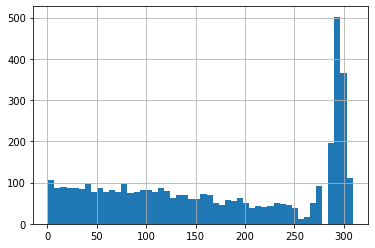

In [30]:
pick_hist = data.pick.hist(bins=50)

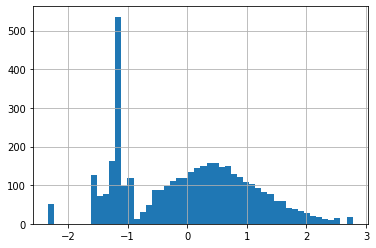

In [31]:
pick_score_hist = data.pick_score.hist(bins=50)

In [32]:
data.conf.value_counts()

SEC         863
ACC         675
Big Ten     641
Pac-10      615
Big 12      513
Other       368
MWC         189
CUSA        152
WAC         130
MAC         121
Ind         104
Sun Belt     48
Name: conf, dtype: int64

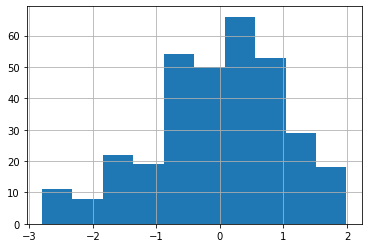

In [33]:
oline.win_pct.hist()

Top college counts not being merged

In [34]:
(data.loc[~data.college.isin(cfb_standings.School)].college.value_counts().head(20))

Louisiana-Lafayette    3
Alabama-Birmingham     3
North Alabama          2
Kansas St.             2
Texas-San Antonio      2
Delaware               2
Boise St.              2
Idaho State            2
Appalachian St.        1
Louisiana St           1
Alabama State          1
Colorado St.           1
Ball St.               1
San Diego              1
Richmond               1
Samford                1
Morgan State           1
Mississippi St.        1
Sam Houston State      1
North Dakota St        1
Name: college, dtype: int64

Players with colleges not getting merged:

In [35]:
data.loc[data.wins.isnull()].head(10)

url   pick team  year  \
127  https://www.sports-reference.com/cfb/players/a...    NaN  NaN  2018   
150  https://www.sports-reference.com/cfb/players/a...  284.5  NaN  2004   
154  https://www.sports-reference.com/cfb/players/a...    NaN  NaN  2018   
232  https://www.sports-reference.com/cfb/players/a...    NaN  NaN  2018   
343  https://www.sports-reference.com/cfb/players/b...  215.0  ARI  2007   
509  https://www.sports-reference.com/cfb/players/b...    NaN  NaN  2018   
576  https://www.sports-reference.com/cfb/players/b...    NaN  NaN  2018   
641  https://www.sports-reference.com/cfb/players/c...    2.0  PHI  2016   
663  https://www.sports-reference.com/cfb/players/c...    NaN  NaN  2018   
676  https://www.sports-reference.com/cfb/players/c...  296.0  NaN  2008   

      pos           player          college  missing_combine_vals  \
127    WR     Allen Lazard         Iowa St.                     2   
150    WR   Andrae Thurman  Southern Oregon                     1   
154    CB   Andre Chachere     San Jose St.                     0   
232  EDGE  Anthony Winbush         Ball St.                     4   
343    TE      Ben Patrick         Delaware                     1   
509     C      Brian Allen     Michigan St.                     0   
576    WR    Byron Pringle       Kansas St.                     0   
641    QB     Carson Wentz  North Dakota St                     1   
663    WR   Cedrick Wilson        Boise St.                     0   
676    RB     Chad Simpson     Morgan State                     3   

     height_inches  weight  ...  conf_CUSA  conf_Ind  conf_MAC  conf_MWC  \
127             77     227  ...          0         0         0         0   
150             71     192  ...          0         0         0         0   
154             72     200  ...          0         0         0         0   
232             73     249  ...          0         0         0         0   
343             75     252  ...          0         0         0         0   
509             73     298  ...          0         0         0         0   
576             73     203  ...          0         0         0         0   
641             77     237  ...          0         0         0         0   
663             74     197  ...          0         0         0         0   
676             69     216  ...          0         0         0         0   

     conf_Other  conf_Pac-10  conf_SEC  conf_Sun Belt  conf_WAC  power5  
127           1            0         0              0         0       0  
150           1            0         0              0         0       0  
154           1            0         0              0         0       0  
232           1            0         0              0         0       0  
343           1            0         0              0         0       0  
509           1            0         0              0         0       0  
576           1            0         0              0         0       0  
641           1            0         0              0         0       0  
663           1            0         0              0         0       0  
676           1            0         0              0         0       0  

[10 rows x 97 columns]